In [15]:
import cv2
import easyocr
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm
import re



In [16]:

# def extract_frame(video_path, frame_number=0):
#     # Open the video file
#     cap = cv2.VideoCapture(video_path)
    
#     # Check if video opened successfully
#     if not cap.isOpened():
#         print("Error: Could not open video.")
#         return
    
#     # Get video properties
#     total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
#     fps = cap.get(cv2.CAP_PROP_FPS)
    
#     # print(f"Total frames: {total_frames}")
#     # print(f"FPS: {fps}")
    
#     # Set frame position
#     cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    
#     # Read frame
#     ret, frame = cap.read()
    
#     if not ret or frame is None:
#         print("Error: Could not read frame.")
#         return None, total_frames, fps
    
#     # Release video capture object
#     cap.release()

#     return frame, total_frames, fps

# ...existing code...
import math
from tqdm.auto import tqdm

def extract_frame(video_path, frame_number=0):
    # Try multiple OpenCV backends
    cap = None
    for backend in (cv2.CAP_ANY, cv2.CAP_FFMPEG, cv2.CAP_GSTREAMER):
        try:
            cap = cv2.VideoCapture(video_path) if backend == cv2.CAP_ANY else cv2.VideoCapture(video_path, backend)
            if cap.isOpened():
                break
            cap.release()
            cap = None
        except Exception:
            cap = None

    if cap is None or not cap.isOpened():
        tqdm.write(f"[WARN] Could not open video: {video_path}")
        return None, None, None

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    fps = cap.get(cv2.CAP_PROP_FPS) or 0.0
    try:
        if math.isnan(fps):
            fps = 0.0
    except Exception:
        pass

    # Clamp requested frame into range
    if total_frames > 0 and frame_number >= total_frames:
        frame_number = max(0, total_frames - 1)

    if frame_number > 0:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

    ret, frame = cap.read()

    if not ret or frame is None:
        # Fallback: read first frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
        ret, frame = cap.read()

    cap.release()

    if not ret or frame is None:
        tqdm.write(f"[WARN] Could not read a frame from: {video_path}")
        return None, (total_frames or None), (fps or None)

    return frame, total_frames, fps
# ...existing code...
# Usage examples
video_path = '/cosma7/data/dp004/rrtx34/ultrasound/UHW/Case-10-Bryson/BRYSON-LU-1/DRYSON-LU-1_0001.MP4'

# Extract single frame (frame 10)
frame, total_frames, fps = extract_frame(video_path, 10)


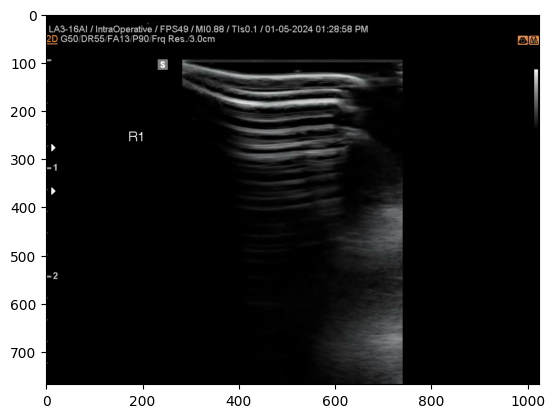

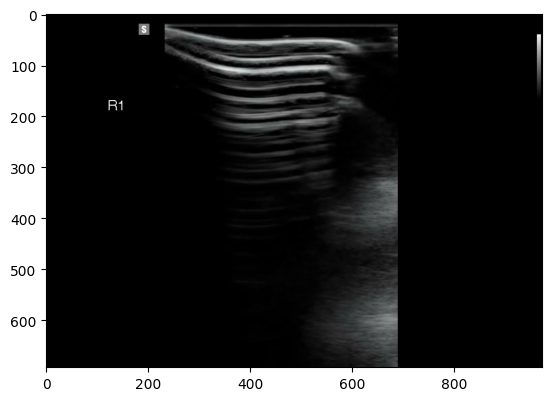

In [17]:

plt.imshow(frame)
plt.show()

# frame_cut = frame[110:280,:300]
# plt.imshow(frame_cut)

scan_label_cut = frame[75:, 50:]
plt.imshow(scan_label_cut)

/cosma/home/durham/dc-fras4/.conda/envs/LUS/lib/python3.12/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[('R1', np.float64(0.9442872036404986))]

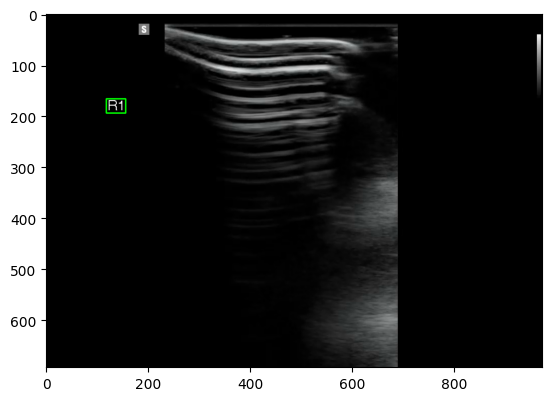

In [18]:
import easyocr
import cv2
import numpy as np

def read_text(image_path, min_confidence=0.0, reader=None):
    # Initialize reader for English only
    if reader is None:
        reader = easyocr.Reader(['en'], gpu=True, verbose=False)

    if not isinstance(image_path, np.ndarray):
        # Read image

        image = cv2.imread(image_path)
    else:
        image = image_path
    
    # Perform OCR - lowered text_threshold to catch more detections
    results = reader.readtext(
        image,
        detail=1,
        allowlist='ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789/',
        text_threshold=0.1,  # Lower threshold to catch more text
        paragraph=False
    )
    
    # Draw results on image and print text
    detected_texts = []
    for (bbox, detected_text, prob) in results:
        # Only include results above minimum confidence
        if prob < min_confidence:
            continue
            
        # Get corner points
        (top_left, top_right, bottom_right, bottom_left) = bbox
        top_left = tuple(map(int, top_left))
        bottom_right = tuple(map(int, bottom_right))
        
    #     # Draw rectangle and text
        cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)
    #     cv2.putText(image, detected_text, (top_left[0], top_left[1] - 10),
    #                 cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
    
        detected_texts.append((detected_text, prob))
        # print(f"Text: {detected_text} (Confidence: {prob:.2f})")
    
    # Display result
    # cv2.imshow("Result", image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    plt.imshow(image)
    return detected_texts

# Usage
image_path = scan_label_cut
read_text(image_path, min_confidence=0.0)  # Set to 0.0 to see all detections

In [19]:
# get scan label from detected texts
# detected_texts = read_text(image_path, min_confidence=0.0)
# scan_label = None
possibilities = ['R1', 'R2', 'R3', 'RP1', 'RP2', 'L1', 'L2', 'L3', 'LP1', 'LP2']

def find_scan_label(detected_texts, possibilities):
    for text, prob in detected_texts:
        if text in possibilities:
            if prob >= 0.5:  # confidence threshold
                return text
    return None



Directory exists: True -> /cosma7/data/dp004/rrtx34/ultrasound/UHW
Sample entries: ['Case-6-McCormick', 'Case-5-MCGLYNN', 'Case-8-Garcia', 'NeoLU report -Final.jpg', 'Case-11-Sheridan']


Indexing videos in UHW: 0it [00:00, ?it/s]

Indexing videos in Case-6-McCormick: 0it [00:00, ?it/s]

Indexing videos in MCCORMICK-LU-3:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in MCCORMICK-LU-4:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in MCCORMICK-LU-1:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in MCCORMICK-LU-2:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in Case-5-MCGLYNN: 0it [00:00, ?it/s]

Indexing videos in MCGLYNN-SCAN-2:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in MCGLYNN-SCAN-1:   0%|          | 0/15 [00:00<?, ?it/s]

Indexing videos in MCGLYNN-SCAN-3:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in MCGLYNN-SCAN-4:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in Case-8-Garcia: 0it [00:00, ?it/s]

Indexing videos in GARCIA-LU-2:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in GARCIA-LU-4:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in GARCIA-LU-1:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in GARCIA-LU-3:   0%|          | 0/17 [00:00<?, ?it/s]

Indexing videos in Case-11-Sheridan: 0it [00:00, ?it/s]

Indexing videos in SHERIDAN-LU-1:   0%|          | 0/12 [00:00<?, ?it/s]

Indexing videos in SHERIDAN-LU-4:   0%|          | 0/16 [00:00<?, ?it/s]

Indexing videos in SHERIDAN-LU-3:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in SHERIDAN-LU-2:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in Case-1- Leitch: 0it [00:00, ?it/s]

Indexing videos in LEITCH-LU-1:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in LEITCH-LU-4:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in LEITCH-LU-3:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in LEITCH-LU-2:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in Case-4-Young: 0it [00:00, ?it/s]

Indexing videos in YOUNG-SCAN-3:   0%|          | 0/12 [00:00<?, ?it/s]

Indexing videos in YOUNG-SCAN-1:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in YOUNG-SCAN-4:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in YOUNG-SCAN-2:   0%|          | 0/18 [00:00<?, ?it/s]

Indexing videos in Case-10-Bryson: 0it [00:00, ?it/s]

Indexing videos in BRYSON-LU-2:   0%|          | 0/12 [00:00<?, ?it/s]

Indexing videos in BRYSON-LU-1:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in BRYSON-LU-3:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in BRYSON-LU-4:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in Case-2- Rodger: 0it [00:00, ?it/s]

Indexing videos in RODGERS-LU-3:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in RODGERS-LU-2:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in RODGERS-LU-4:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in RODGERS-LU-1:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in Case-9-ONIBON: 0it [00:00, ?it/s]

Indexing videos in ONIBON-LU-1: 0it [00:00, ?it/s]

Indexing videos in ONIBON-LU-3:   0%|          | 0/12 [00:00<?, ?it/s]

Indexing videos in ONIBON-LU-2:   0%|          | 0/12 [00:00<?, ?it/s]

Indexing videos in ONIBON-LU4:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in Excluded scans: 0it [00:00, ?it/s]

Indexing videos in Ventilated cases-On RedCAP: 0it [00:00, ?it/s]

Indexing videos in Case-7-Digan: 0it [00:00, ?it/s]

Indexing videos in DIGAN-LU-1:   0%|          | 0/25 [00:00<?, ?it/s]

Indexing videos in DIGAN-LU-4:   0%|          | 0/67 [00:00<?, ?it/s]

Indexing videos in DIGAN-LU-3:   0%|          | 0/29 [00:00<?, ?it/s]

Indexing videos in DIGAN-LU-2:   0%|          | 0/46 [00:00<?, ?it/s]

Indexing videos in Case-3-Boyd: 0it [00:00, ?it/s]

Indexing videos in Boyd-scan-3:   0%|          | 0/26 [00:00<?, ?it/s]

Indexing videos in Boyd-Scan-4 day-7:   0%|          | 0/24 [00:00<?, ?it/s]

Indexing videos in Boyd-Scan-2:   0%|          | 0/30 [00:00<?, ?it/s]

Indexing videos in Boyd-Scan-1:   0%|          | 0/20 [00:00<?, ?it/s]

Indexing videos in Case -Vida-Incomplete-NOT on REDCAP: 0it [00:00, ?it/s]

Indexing videos in VIDA-LU-2: 0it [00:00, ?it/s]

Indexing videos in VIDA-LU-3: 0it [00:00, ?it/s]

Indexing videos in VIDA-LU-1: 0it [00:00, ?it/s]

Extracting scan labels (OCR):   0%|          | 0/662 [00:00<?, ?it/s]

/cosma/home/durham/dc-fras4/.conda/envs/LUS/lib/python3.12/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


    Hospital                                          File Path Patient ID  \
0        UHW  /cosma7/data/dp004/rrtx34/ultrasound/UHW/Case-...    Unknown   
1        UHW  /cosma7/data/dp004/rrtx34/ultrasound/UHW/Case-...    Unknown   
2        UHW  /cosma7/data/dp004/rrtx34/ultrasound/UHW/Case-...    Unknown   
3        UHW  /cosma7/data/dp004/rrtx34/ultrasound/UHW/Case-...    Unknown   
4        UHW  /cosma7/data/dp004/rrtx34/ultrasound/UHW/Case-...    Unknown   
..       ...                                                ...        ...   
657      UHW  /cosma7/data/dp004/rrtx34/ultrasound/UHW/Exclu...    Unknown   
658      UHW  /cosma7/data/dp004/rrtx34/ultrasound/UHW/Exclu...    Unknown   
659      UHW  /cosma7/data/dp004/rrtx34/ultrasound/UHW/Exclu...    Unknown   
660      UHW  /cosma7/data/dp004/rrtx34/ultrasound/UHW/Exclu...    Unknown   
661      UHW  /cosma7/data/dp004/rrtx34/ultrasound/UHW/Exclu...    Unknown   

    Scan No  Total Frames   FPS Scan Label  
0     LUS_3       

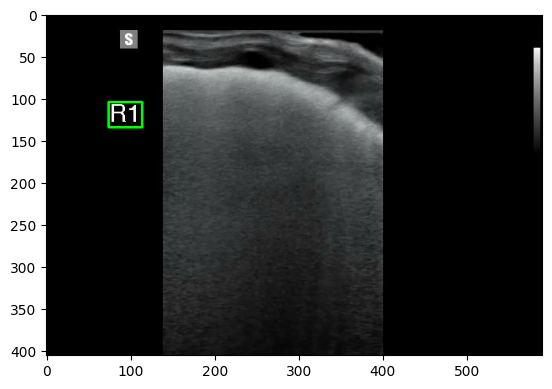

In [22]:


# Set the directory path
dir_path = r'/cosma7/data/dp004/rrtx34/ultrasound/UHW'

# Diagnostics
print(f"Directory exists: {os.path.exists(dir_path)} -> {dir_path}")
if os.path.exists(dir_path):
    try:
        print("Sample entries:", os.listdir(dir_path)[:5])
    except Exception as e:
        print("Could not list directory contents:", e)

# Create an empty list to store the file names and paths
file_list = []

# Walk through the directory and its subdirectories
for root, dirs, files in os.walk(dir_path):
    files = [ fi for fi in files if fi.endswith(".AVI") or fi.endswith(".MP4") and not fi.startswith("VIDA") or fi.startswith("BOYD") or fi.startswith("DIGAN") ]
    for file in tqdm(files, desc=f"Indexing videos in {os.path.basename(root)}", leave=False):
        # Get the file path
        file_path = os.path.join(root, file)
        scan_filename = os.path.split(os.path.dirname(file_path))[-1]
        re_match = re.search(r'[1-4]', scan_filename)
        scan_no = f'LUS_{re_match.group(0)}' if re_match else 'LUS_Unknown'

        patient_id_filename = os.path.split(os.path.dirname(os.path.dirname(file_path)))[-1]
        re_match_1 = re.search(r'[0-11]', patient_id_filename)
        patient_id = re_match_1.group(0) if re_match_1 else 'Unknown'
        # Append the file name and path to the list
        file_list.append({'Hospital': 'UHW', 'File Path': file_path, 'Patient ID': patient_id, 'Scan No': scan_no})

ocr_reader = easyocr.Reader(['en'], gpu=True, verbose=False)
# add scan label column
for file_info in tqdm(file_list, desc="Extracting scan labels (OCR)"):
    video_path = file_info['File Path']
    frame, total_frames, fps = extract_frame(video_path, frame_number=10)

    file_info['Total Frames'] = total_frames or 0
    file_info['FPS'] = fps or 0.0

    if frame is None:
        file_info['Scan Label'] = 'Unknown'
        file_info['Read Error'] = True
        continue

    h, w = frame.shape[:2]
    y0, x0 = 75, 50
    scan_label_cut = frame[min(y0, h):h, min(x0, w):w]

    detected_texts = read_text(scan_label_cut, min_confidence=0.0, reader=ocr_reader)
    scan_label = find_scan_label(detected_texts, possibilities)
    file_info['Scan Label'] = scan_label if scan_label else 'Unknown'

    if file_info['Scan No'] == 'LUS_4':
        file_info['Scan No'] = 'LU_4'


# Create a Pandas DataFrame from the list
df_path = pd.DataFrame(file_list)

print(df_path)

In [ ]:
# Change scan label to expert scan label
def to_expert_label(label: str) -> str:
    s = str(label).upper()
    if s in ("RLAT", "RLATERAL", "RAX", "RLT"):
        return "Rax"
    if s == "RUA":
        return "RAA"
    if s == "RLA":
        return "RAB"
    if s == "RUP":
        return "RPA"
    if s == "RLP":
        return "RPB"
    if s == "LUA":
        return "LAA"
    if s == "LLA":
        return "LAB"
    if s in ("LLAT", "LLATERAL", "LAX", "LLT"):
        return "LAX"
    if s == "LUP":
        return "LPA"
    if s == "LLP":
        return "LPB"
    return label

df_path["Scan Label"] = df_path["Scan Label"].apply(to_expert_label)

In [ ]:
# Add score
scores_directory = '/cosma7/data/dp004/rrtx34/ultrasound/Virginie_scores/Scores_JCUH'

def add_scores(df, scores_directory):
    # find patient score file
    for i in tqdm(df.index, desc="Adding scores"):
        patient_id = df.at[i, 'Patient ID']
        scan_no = df.at[i, 'Scan No']
        scan_label = df.at[i, 'Scan Label']

        df_score = None
        for file in os.listdir(scores_directory):
            if file.endswith(f"{patient_id}.xlsx"):
                df_score = pd.ExcelFile(os.path.join(scores_directory, file))
                sheets = df_score.sheet_names
                df_score = pd.read_excel(df_score, sheet_name=sheets[-1])
                break
        if df_score is None:
            continue
        # clean score data frames to remove empty rows and columns
        for col in df_score.columns:
            if df_score[col].isnull().all():
                df_score = df_score.drop(columns=[col])

        for index, row in df_score.iterrows():
            if row.isnull().all():
                df_score = df_score.drop(index=index)

        # make first row and column header
        df_score.columns = df_score.iloc[0]
        df_score = df_score[1:]
        df_score = df_score.set_index(df_score.columns[0])

        # add score to main dataframe
        if scan_label in df_score.index and scan_no in df_score.columns:
            score = df_score.at[scan_label, scan_no]
            df.at[i, 'Score'] = score

    return df
        
df_path = add_scores(df_path, scores_directory)
                

Adding scores:   0%|          | 0/1595 [00:00<?, ?it/s]

/tmp/ipykernel_520/1884162102.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'ni' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'Score'] = score


In [ ]:
# Save DataFrame to CSV
# df_path.to_csv('LUS_data.csv')

In [ ]:
#  Print rows with unknown scan labels from LUS_data.csv
df_loaded = pd.read_csv('LUS_data.csv')
unknown_scan_labels = df_loaded[df_loaded['Scan Label'] == 'Unknown']

# make new csv with unknown scan labels
unknown_scan_labels.to_csv('LUS_data_unknown_scan_labels.csv', index=False)

